# 3D Simulations

Running 3D simulations should be as easy as adding an extra axis to the domain size and discretization step.

In [1]:
from jwave.geometry import Domain

N, dx = (64, 64, 64), (0.1e-3, 0.1e-3, 0.1e-3)
domain = Domain(N, dx)

In [2]:
from jax import numpy as jnp
from jwave.geometry import Medium, TimeAxis, _sphere_mask, _fibonacci_sphere, Sensors

sound_speed = jnp.ones(N)*1500
medium = Medium(domain=domain, sound_speed=sound_speed)

time_axis = TimeAxis.from_medium(medium, cfl=0.3)
output_time_axis = TimeAxis(time_axis.dt*20, time_axis.t_end//2)

# sensors
num_sensors = 64
x, y, z = _fibonacci_sphere(num_sensors,20,(32,32,32))
sensors_positions = (jnp.array(x), jnp.array(y), jnp.array(z))
sensors = Sensors(positions=sensors_positions)

Text(0.5, 0.92, 'Sensor locations')

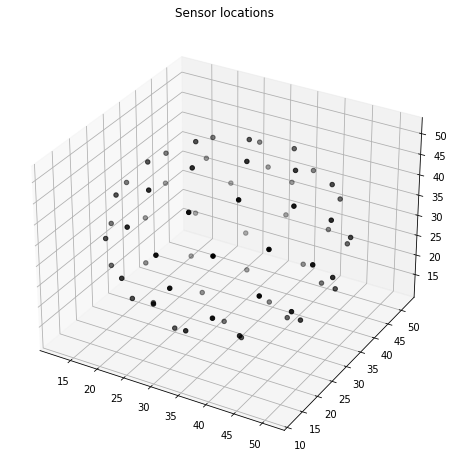

In [4]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z, marker='o', color="black")
ax.set_title("Sensor locations")

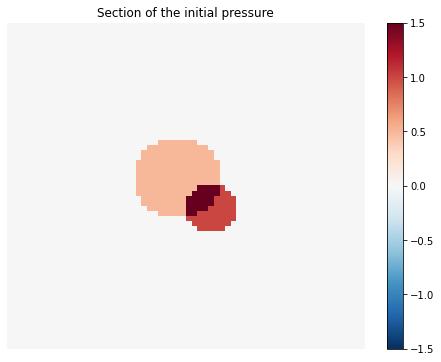

In [17]:
from jwave.utils import show_field

# Initial pressure is a sphere
p0 = jnp.zeros(domain.N)
p0 = _sphere_mask(domain.N, 5, (32,36,36))*1.0 + _sphere_mask(domain.N, 8, (32,30,30))*.5

show_field(p0[32], 'Section of the initial pressure')

In [18]:
from jwave.acoustics import ongrid_wave_propagation
from jax import jit

params, solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    output_t_axis = time_axis,
    backprop=True,
    sensors=sensors,
    p0 = p0
)

solver = jit(solver)
sensors_data = solver(params)

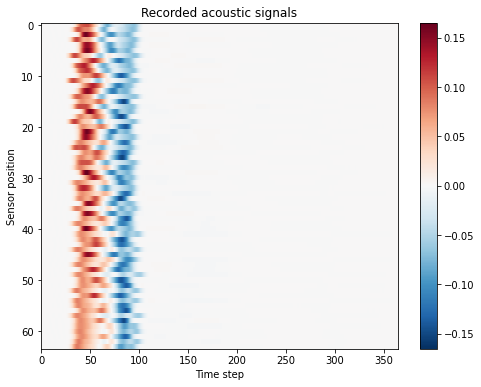

In [19]:
from jwave.utils import show_field

show_field(sensors_data.T, "Recorded acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

In [20]:
%timeit solver(params).block_until_ready()

202 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Automatic differentiation

We can take the gradient with respect to any scalar loss, as shown in the following example.
Note that taking gradients with autodiff can be also used to generate imaging algorithms:

In [25]:
from jwave.signal_processing import smooth
from jax import random

noise = random.normal(random.PRNGKey(42), sensors_data.shape)
for i in range(noise.shape[1]):
    noise = noise.at[:,i].set(smooth(noise[:,i]))

noisy_data = sensors_data + 0.05*noise

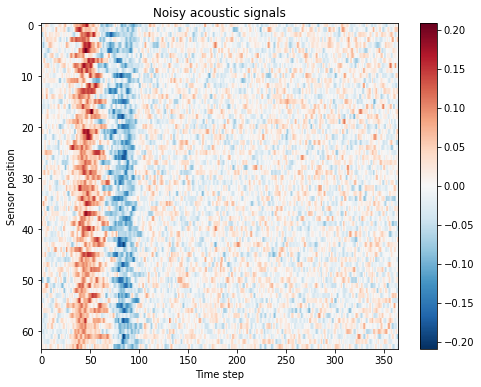

In [26]:
show_field(noisy_data.T, "Noisy acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

In [27]:
from jax import grad

@jit # Compile the whole algorithm
def lazy_time_reversal(p):

    def mse_loss(p0):
        local_params = params.copy()
        local_params["initial_fields"]["p"] = p0
        p_pred = solver(local_params)
        return 0.5*jnp.sum(jnp.abs(p_pred - p)**2)
    
    p0 = jnp.zeros_like(params["initial_fields"]["p"])
    p_grad = grad(mse_loss)(p0)
    
    return -p_grad


recon_image = lazy_time_reversal(noisy_data)

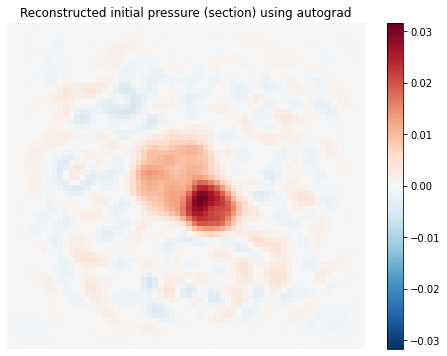

In [28]:
show_field(recon_image[32], 'Reconstructed initial pressure (section) using autograd')

In [29]:
%timeit lazy_time_reversal(noisy_data).block_until_ready()

460 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
